In [1]:
from scipy.stats import skew, kurtosis
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
import pandas as pd
from scipy.stats import entropy
import math
import keras

Using TensorFlow backend.


In [2]:
def entropy1(labels, base=None):
  value,counts = np.unique(labels, return_counts=True)
  return entropy(counts, base=base)

In [3]:
df = pd.read_csv("./data/icici_04-18_clean.csv")
df = df['Close'][0:-2].values

In [4]:
train = df[0: int(math.floor(0.75 * len(df)))]
valid = df[int(math.floor(0.75 * len(df))):]

In [5]:
print(df.shape)

(3549,)


In [6]:
print(train.shape, valid.shape)

(2661,) (888,)


In [7]:
x_train, y_train = [], []
for i in range(7,len(train)):
    x_train.append(train[i-7:i])
    y_train.append(train[i])
x_train, y_train = np.array(x_train), np.array(y_train)

In [8]:
y_train.shape

(2654,)

In [9]:
inputs = df[len(train) - 7:]
x_test = []

for i in range(7,inputs.shape[0]):
    x_test.append(inputs[i-7:i])
x_test = np.array(x_test)
print(x_test.shape)

(888, 7)


In [10]:
a = x_train
Feature_array = []
for row in range(0,a.shape[0]):
    mean = np.mean(a[row])
    f = np.array([mean])
    skewness = skew(a[row], axis=0, bias=True)
    f = np.append(f, skewness)
    kurt = kurtosis(a[row], axis=0, fisher=True, bias=True)
    f= np.append(f, kurt)
    variance = np.var(a[row])
    f = np.append(f, variance)
    std = np.std(a[row])
    f = np.append(f, std)
    x = np.arange(0,len(a[row]),1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,a[row])
    f = np.append(f, slope)
    f = np.append(f, entropy1(a[row]))
    df = pd.DataFrame({'A' : a[row]})
    f = np.append(f,df.ewm(alpha = 0.6).mean().iloc[-1,0])
    Feature_array.append(f)
    
Feature_train = np.asarray(Feature_array)

a = x_test
Feature_array = []
for row in range(0,a.shape[0]):
    mean = np.mean(a[row])
    f = np.array([mean])
    skewness = skew(a[row], axis=0, bias=True)
    f = np.append(f, skewness)
    kurt = kurtosis(a[row], axis=0, fisher=True, bias=True)
    f= np.append(f, kurt)
    variance = np.var(a[row])
    f = np.append(f, variance)
    std = np.std(a[row])
    f = np.append(f, std)
    x = np.arange(0,len(a[row]),1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,a[row])
    f = np.append(f, slope)
    f = np.append(f, entropy1(a[row]))
    df = pd.DataFrame({'A' : a[row]})
    f = np.append(f,df.ewm(alpha = 0.6).mean().iloc[-1,0])
    Feature_array.append(f)
    
Feature_test = np.asarray(Feature_array)

In [12]:
x_train = np.reshape(Feature_train, (Feature_train.shape[0],Feature_train.shape[1],1))
x_test = np.reshape(Feature_test, (Feature_test.shape[0],Feature_test.shape[1],1))

# create and fit the LSTM network
model = keras.models.Sequential()
model.add(keras.layers.CuDNNLSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(keras.layers.CuDNNLSTM(units=50))
model.add(keras.layers.Dense(1))
model.summary()
model.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam())
model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_3 (CuDNNLSTM)     (None, 8, 50)             10600     
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 50)                20400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 31,051
Trainable params: 31,051
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


UnknownError: Fail to find the dnn implementation.
	 [[Node: cu_dnnlstm_3/CudnnRNN = CudnnRNN[T=DT_FLOAT, _class=["loc:@training/Adam/gradients/cu_dnnlstm_3/CudnnRNN_grad/CudnnRNNBackprop"], direction="unidirectional", dropout=0, input_mode="linear_input", is_training=true, rnn_mode="lstm", seed=87654321, seed2=0, _device="/job:localhost/replica:0/task:0/device:GPU:0"](cu_dnnlstm_3/transpose, cu_dnnlstm_3/ExpandDims_1, cu_dnnlstm_3/ExpandDims_1, cu_dnnlstm_3/concat_1)]]
	 [[Node: loss/mul/_111 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1172_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [ ]:
closing_price = model.predict(x_test)
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
print(rms)

# Train Accuracy and plot

Test loss: 8.01199864752
Test accuracy: 0.558024692241


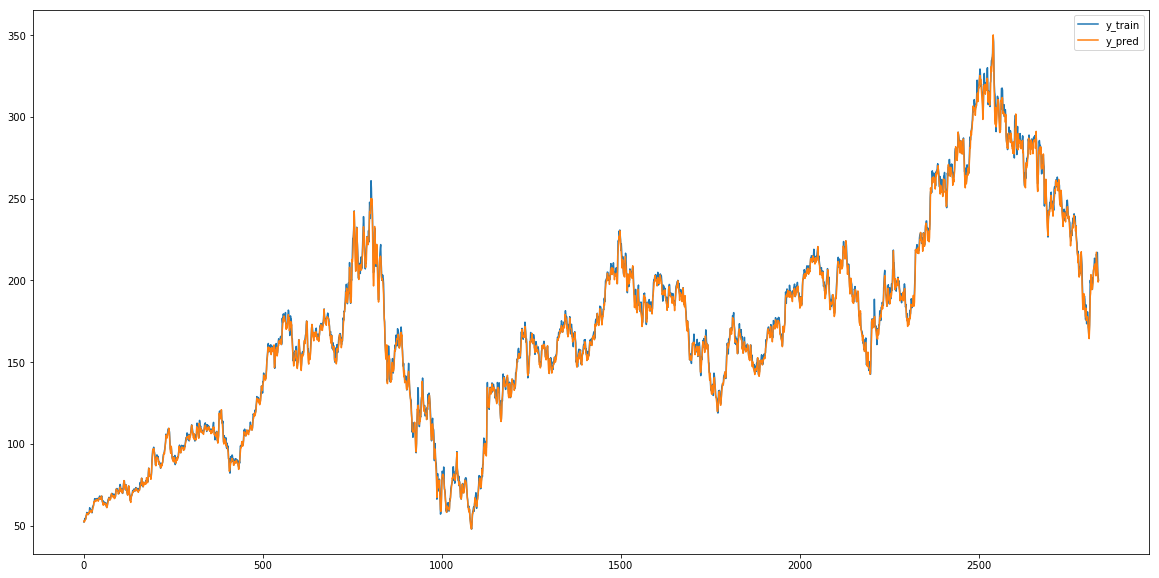

In [12]:
# Best Model
# model.load_weights(filepath)
score = model.evaluate(x_train, y_train, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
y_pred = model.predict(x_train)
plt.figure(figsize=(20,10))
plt.plot(y_train.ravel(), label = 'y_train')
plt.plot(y_pred.ravel(), label = 'y_pred')
plt.legend()

# Test accuracy and plot

In [13]:
# Best Model
# model.load_weights(filepath)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
y_pred = model.predict(x_test)

Test loss: 18.9605015773
Test accuracy: 0.411764705882


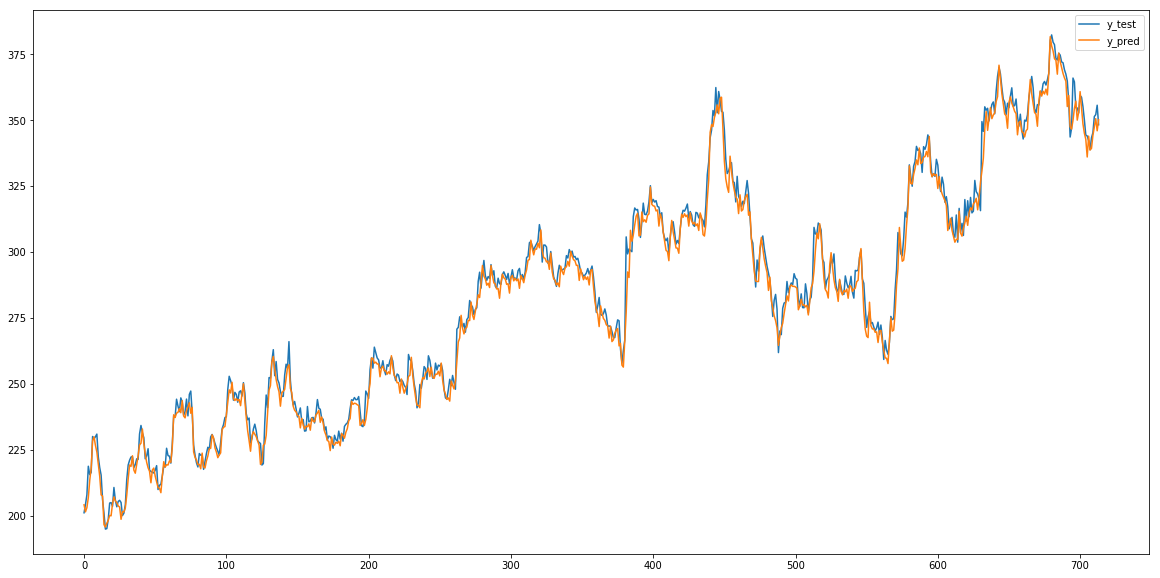

In [14]:
plt.figure(figsize=(20,10))
plt.plot(y_test.ravel(), label = 'y_test')
plt.plot(y_pred.ravel(), label = 'y_pred')
plt.legend()